In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
df= pd.read_csv('/content/GVT data.csv')

In [123]:
df.head()

,Team ID,Virtuality %,date,reopen count,duration,Updated
0,Global 11,96,01/01/2018,0,1445,5
1,Americas 1,82,01/01/2018,0,1583,7
2,US 2,7,01/01/2018,0,25,6
3,US 2,7,01/01/2018,0,26,8
4,Global 5,98,01/01/2018,0,1198,5


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59267 entries, 0 to 59266
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Team ID       59267 non-null  object
 1   Virtuality %  59267 non-null  int64 
 2   date          59267 non-null  object
 3   reopen count  59267 non-null  int64 
 4   duration      59267 non-null  int64 
 5   Updated       59267 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


1. Virtuality % = Cât de mult lucrează echipa remote
2. reopen count = De cate ori a fost refăcut un task
3. duration = Timpul unui task
4. Updated = Cat de des a fost modificat un task de la inceput pana la reopen

In [125]:
df.shape


(59267, 6)

In [126]:
df['duration'].describe()

,duration
count,59267.000000
mean,5048.554103
std,7955.591933
min,1.000000
25%,100.000000
50%,1447.000000
75%,6740.000000
max,43321.000000


In [127]:
df['duration_hours'] = df['duration'] / 60

In [128]:
df.isnull().sum()

,0
Team ID,0
Virtuality %,0
date,0
reopen count,0
duration,0
Updated,0
duration_hours,0


In [129]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

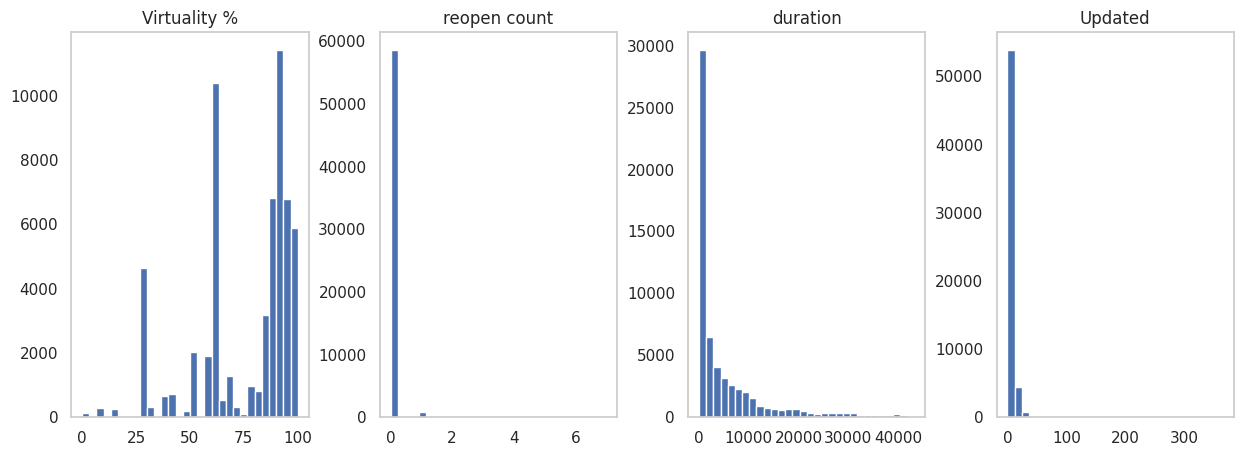

In [130]:
numeric_cols = ['Virtuality %', 'reopen count', 'duration', 'Updated']

df[numeric_cols].hist(bins=30, figsize=(15,5), layout=(1,4), grid=False)
plt.show()


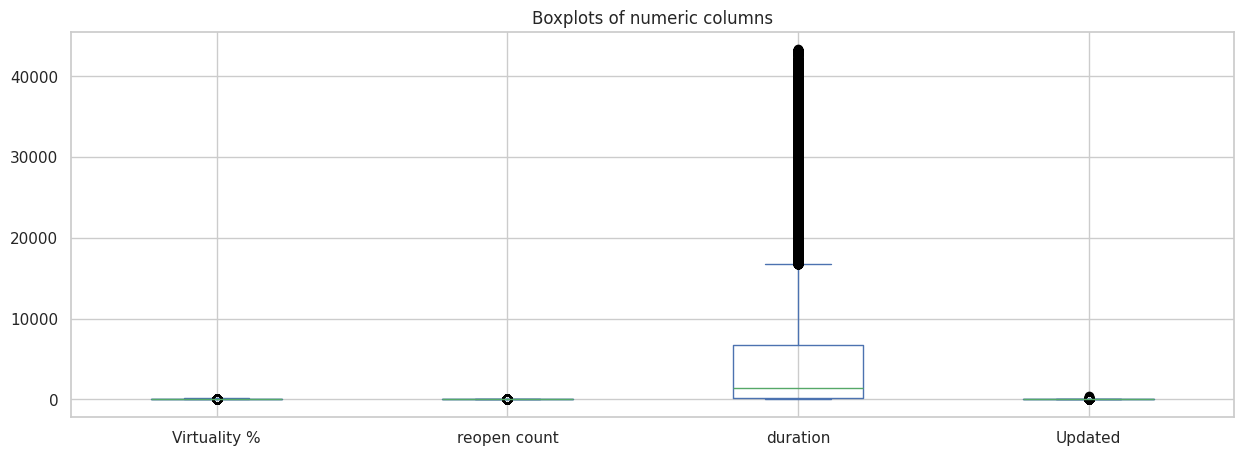

In [131]:
df[numeric_cols].plot.box(figsize=(15,5))
plt.title("Boxplots of numeric columns")
plt.show()

In [132]:
col = 'duration'

In [133]:
Q1= df[col].quantile(0.25)
Q3= df[col].quantile(0.75)
IQR= Q3-Q1

In [134]:
outliers= df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)]

In [135]:
percent_outliers = len(outliers) / len(df) * 100
print(f"Procentul de outlieri în '{col}' este: {percent_outliers:.2f}%")

Procentul de outlieri în 'duration' este: 9.08%


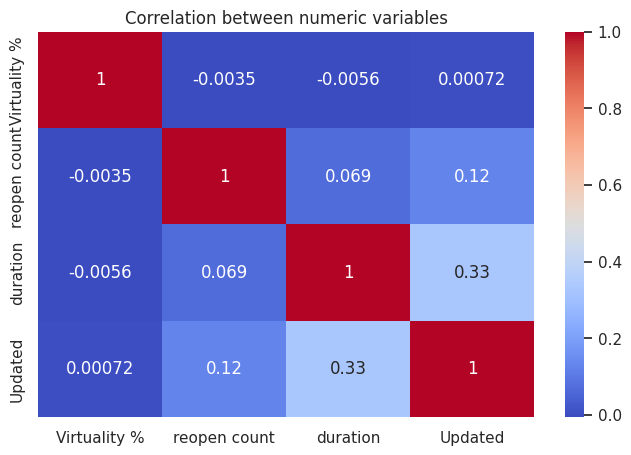

In [136]:
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm").set(title="Correlation between numeric variables")
plt.show()

Date-> DateTime

In [137]:
df['date']= pd.to_datetime(df['date'], dayfirst=True)

Targetul este preventia reopen task


In [138]:
df['task_problematic']= (df['reopen count']>0).astype(int)

Feature-uri

In [139]:
df['day_of_week'] = df['date'].dt.dayofweek  # echipe care pot fi mai productive in anumite yile
df['month'] = df['date'].dt.month    # luni cu mai multe REOPEN
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)  # task in weekend
df['day_of_year']= df['date'].dt.dayofyear   # luna sau sezon - apogeu REOPEN in perioade aglomerate din an sau la finele anului
df['days_since_start']= (df['date']- df['date'].min()).dt.days   # echipe care devin mai productive dupa o perioada sau learning curve

In [140]:
df['high_virtuality']= (df['Virtuality %']> 80).astype(int)    # daca echipa lucreaza preponderent remote  intre 0 1
df['task_long']= (df['duration']> df['duration'].median()).astype(int)   # verif daca durata task ului este mai mare decat val mediana -> task lung = adesea risc mare de reopen deoarece sunt mai complexe
df['multi_updated']= (df['Updated']> df['Updated'].median()).astype(int)   # verif daca un task a fost actualizat mai mult decat valoarea mediana a tuturor task urilot ( task uri cu modificari frecvente)

In [141]:
df['duration_x_virtuality'] = df['duration'] * df['Virtuality %'] # val creste daca task ul e lung si echipa mai mult remote
df['updated_x_duration'] = df['Updated'] * df['duration']    # un task lung cu multe update predispus la erori si REOPEN
df['virtuality_x_updated'] = df['Virtuality %'] * df['Updated']  # echipele remote care fac multe update pot avea risc mare de REOPEN ( remote worl + instability task)

corelatia

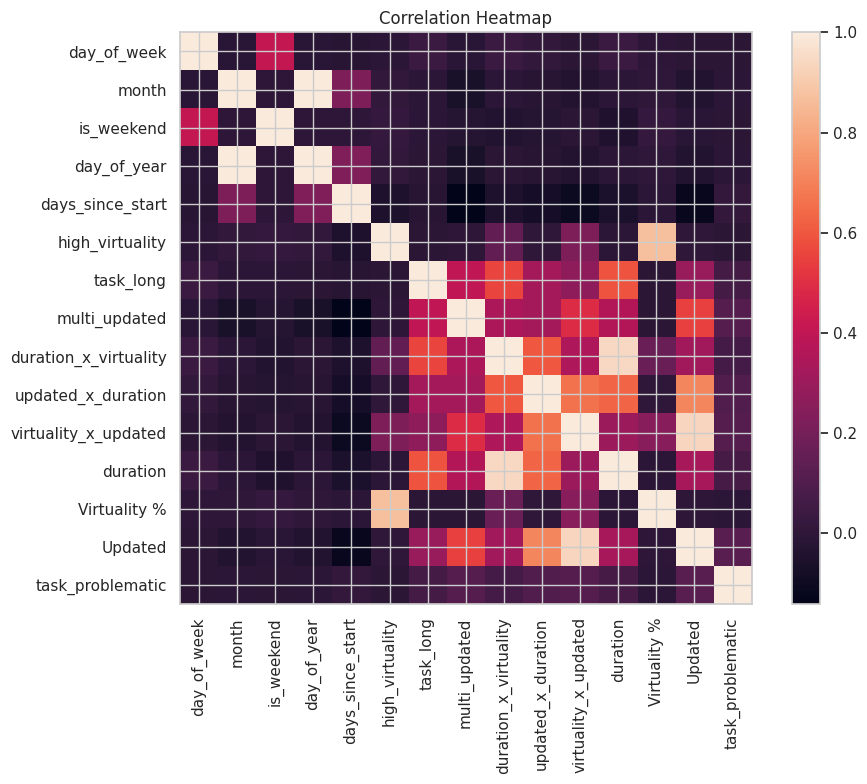

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Matricea completă de corelații
corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.colorbar()
plt.tight_layout()
plt.show()

Agregare


In [143]:
team_stats = df.groupby('Team ID').agg(
  mean_duration_team = ('duration', 'mean'),    # durata medie a task urilor per echipa
  mean_reopen_team = ('reopen count', 'mean') ,  # media reopen per echipa
  count_task_team = ('duration', 'count'),      # volumul de munca, cate task uri are fiecare echipa
  std_duration_team = ('duration', 'std'),     # deviatia standard a duratei per echipa
).reset_index()

team_stats['pct_tasks_reopened_team'] = team_stats['mean_reopen_team']      # procent task uri reopen per echipa


Merge -> fiecare rand din df primeste statisticile echipei-> istoricul echipei ( pattern la nivel de echipa + task)

In [144]:
df = df.merge(team_stats, on='Team ID', how='left')

In [145]:
df = df.sort_values(['Team ID', 'date']).reset_index(drop=True)


rolling -> vreau sa aflu daca o echipa lucreaya mai repede sau mai incet , cate task uri recente ai fost REOPEN per echipa , echipele supraincarcate duc la REOPEN

In [146]:
rolling_window = 30   # test with 7 / 14 / 30 days  - analysis
df['rolling_mean_duration_30d'] = df.groupby('Team ID')['duration'].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df['rolling_sum_reopen_30d'] = df.groupby('Team ID')['reopen count'].transform(lambda x: x.rolling(rolling_window, min_periods=1).sum())
df['rolling_count_tasks_30d'] = df.groupby('Team ID')['duration'].transform(lambda x: x.rolling(rolling_window, min_periods=1).count())


Probleme recurente in echipa -> daca o echipa are mai multe task uri REOPEN in palmares-> o crestere a task problematic

In [147]:
def consecutive_reopen(series):
    count = 0
    max_count = 0
    for val in series:
        if val > 0:
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

consec_reopen = df.groupby('Team ID')['reopen count'].transform(consecutive_reopen)
df['consecutive_reopen_days'] = consec_reopen


Split x si y


In [148]:
features = [
    'Virtuality %', 'duration', 'Updated',
    'day_of_week', 'month', 'is_weekend', 'day_of_year', 'days_since_start',
    'high_virtuality', 'task_long', 'multi_updated',
    'duration_x_virtuality', 'updated_x_duration', 'virtuality_x_updated',
    'mean_duration_team', 'mean_reopen_team', 'count_task_team', 'std_duration_team', 'pct_tasks_reopened_team',
    'rolling_mean_duration_30d', 'rolling_sum_reopen_30d', 'rolling_count_tasks_30d', 'consecutive_reopen_days'
]

X = df[features]
y = df['task_problematic']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (59267, 23)
Target shape: (59267,)


Train, Test


In [149]:
from sklearn.model_selection import train_test_split

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Random forest

In [151]:
from sklearn.ensemble import RandomForestClassifier

Grid Search

gradient // classiefier

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}
Best ROC AUC CV: 0.944798226447824

Confusion Matrix:
[[10288  1413]
 [   18   135]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     11701
           1       0.09      0.88      0.16       153

    accuracy                           0.88     11854
   macro avg       0.54      0.88      0.55     11854
weighted avg       0.99      0.88      0.92     11854

ROC AUC Test Set: 0.9452043928986573


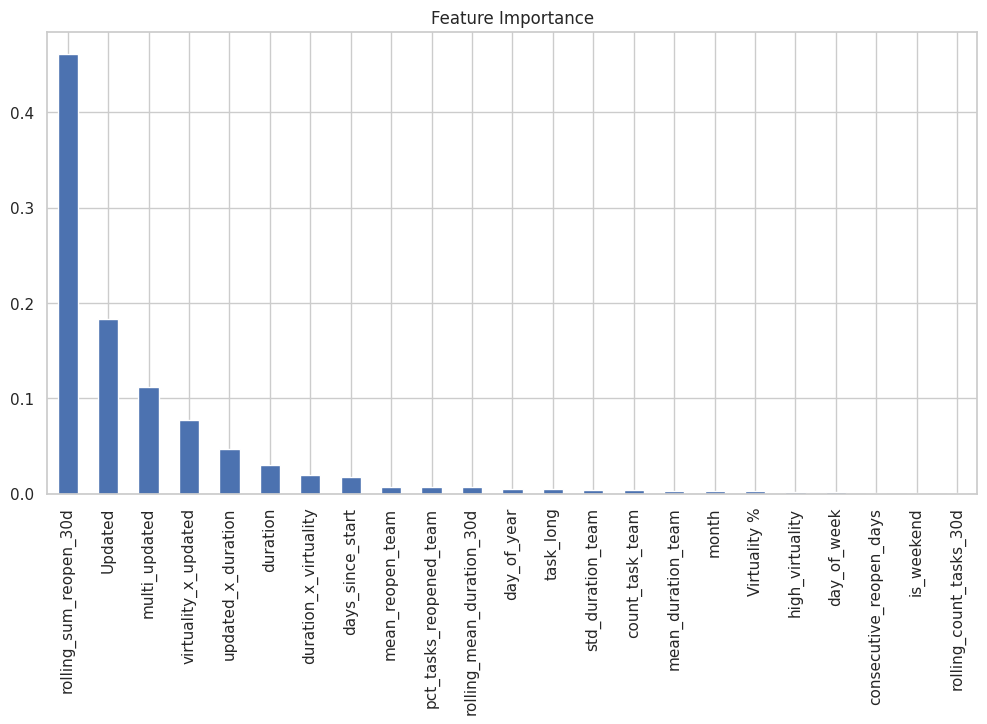

CV ROC AUC scores: [0.94876115 0.94008417 0.94344163 0.95021284 0.93952656]
Mean CV ROC AUC: 0.9444052701662301


In [159]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest de bază
# Added class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Definire parametri pentru RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Randomized Search (rapida)
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,           # testează 20 de combinații random
    cv=3,                # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Antrenare
rand_search.fit(X_train, y_train)

# Cel mai bun model
best_rf = rand_search.best_estimator_
print("Best Parameters:", rand_search.best_params_)
print("Best ROC AUC CV:", rand_search.best_score_)

# Predicții și evaluare
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:,1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Test Set:", roc_auc_score(y_test, y_prob))

# Feature Importance
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(12,6), title="Feature Importance")
plt.show()

# Optional: cross-validation ROC AUC pe tot datasetul
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print("CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", cv_scores.mean())